In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__)); Pkg.instantiate();
using BilinearControl
using BilinearControl.Problems
using BilinearControl.EDMD
import RobotDynamics as RD
using LinearAlgebra
using RobotZoo
using JLD2
using SparseArrays
using Plots
using Distributions
using Distributions: Normal
using Random
using FiniteDiff, ForwardDiff
using Test

  Activating project at `~/.julia/dev/BilinearControl/examples`


In [2]:
Threads.nthreads()

10

In [3]:
include("learned_models/edmd_utils.jl");

In [4]:
## Visualizer
model = Cartpole2()
include(joinpath(Problems.VISDIR, "visualization.jl"))
vis = Visualizer()
delete!(vis)
set_cartpole!(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat Visualizer with path /meshcat/robot/cart/pole at http://127.0.0.1:8702

In [5]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8702))

# Define Cartpole Model

In [6]:
model = Cartpole2()  # this model has damping
dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
tf = 2.0
dt = 0.02;

# Generate Data

In [7]:
Random.seed!(1)
num_test = 50  # number of trajectories
num_train = 50

# Generate a stabilizing LQR controller about the top
Qlqr = Diagonal([0.2,10,1e-2,1e-2])
Rlqr = Diagonal([1e-3])
xe = [0,pi,0,0]
ue = [0.0]
ctrl_lqr = LQRController(dmodel, Qlqr, Rlqr, xe, ue, dt)

# Sample a bunch of initial conditions for the LQR controller
x0_sampler = Product([
    Uniform(-1.0,1.0),
    Uniform(pi-pi/3,pi+pi/3),
    Uniform(-.5,.5),
    Uniform(-.5,.5),
])
initial_conditions_lqr = [rand(x0_sampler) for _ in 1:num_test]
initial_conditions_test = [rand(x0_sampler) for _ in 1:num_train]

# Create data set
X_train, U_train = create_data(dmodel, ctrl_lqr, initial_conditions_lqr, tf, dt)
X_test, U_test = create_data(dmodel, ctrl_lqr, initial_conditions_test, tf, dt);

In [8]:
#save data
jldsave(joinpath(Problems.DATADIR, "cartpole_lqr_trajectories.jld2"); 
    X_train, U_train, X_test, U_test, tf, dt)

# Import Training/Test Data

In [9]:
lqr_traj = load(joinpath(Problems.DATADIR, "cartpole_lqr_trajectories.jld2"))

X_train = lqr_traj["X_train"]
U_train = lqr_traj["U_train"]
X_test = lqr_traj["X_test"]
U_test = lqr_traj["U_test"]
tf = lqr_traj["tf"]
dt = lqr_traj["dt"]

T_ref = range(0,tf,step=dt);

# Fit the Data using Nominal eDMD
This uses the standard eDMD model method used in the CalTech paper, which learns a model of the form:

$$ x^+ = A x + \sum_{i=1}^m u_i C_i x $$

In [10]:
# Define the basis functions
eigfuns = ["state", "sine", "cosine", "sine", "sine", "chebyshev"]
eigorders = [0,0,0,2,4,4];

In [11]:
# Fit the data
Z_train, Zu_train, kf = build_eigenfunctions(X_train, U_train, eigfuns, eigorders)

# A, B, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
#     ["ridge", "na"]; 
#     edmd_weights=[10.1], 
#     mapping_weights=[0.0], 
#     algorithm=:qr
# );

A, B, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
    ["na", "na"]; 
    edmd_weights=[0.0], 
    mapping_weights=[0.0], 
    algorithm=:qr
);

(T, K) = (165000, 2211)
issparse(X) = true
lambda = 0.0
(T, K) = (20000, 132)
issparse(X) = true
lambda = 0.0


In [12]:
# Save model
jldsave(joinpath(Problems.DATADIR,"cartpole_lqr_nominal_eDMD_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

# Import Nominal EDMD Model

In [13]:
cartpole_data = load(joinpath(Problems.DATADIR, "cartpole_lqr_nominal_eDMD_data.jld2"))
A_nom = cartpole_data["A"]
B_nom = cartpole_data["B"]
C_nom = cartpole_data["C"]
g_nom = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"];

# Evaluate the Nominal Fit
The fit is evaluated using:
$$ \frac{1}{P} \sum_{j=1}^P || g (A \varphi(x_j) + \sum_{i=1}^m u_{j,i} C_i \varphi(x_j)) - x_j^+ || $$

where $y = \varphi(x)$ is the Koopman transform.

In [14]:
err_train = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_train, U_train)
err_test = BilinearControl.EDMD.fiterror(A_nom, B_nom, C_nom, g_nom, kf, X_test, U_test)
println("Train Error: ", err_train)
println("Test Error:  ", err_test)

Train Error: 0.0034957043768757694
Test Error:  0.008698930470642706


### Define the Bilinear Model

In [15]:
model_bilinear = EDMDModel(A_nom,B_nom,C_nom,g_nom,kf,dt,"cartpole")
n,m = RD.dims(model_bilinear)
n0 = originalstatedim(model_bilinear)
println("New state dimension: ", n)

New state dimension: 33


### Compare Linearization
To see if the learned model captures the dynamics, we'll evaluate the effective `A` and `B` dynamics Jaocbians of the learned model on the original dynamics, and compare to the nominal Jacobians.

In [16]:
# Define the equilibrium
xe = [0.,pi,0,0]
ue = [0.0]
ze = RD.KnotPoint{n0,m}(xe,ue,0.0,dt)
ye = expandstate(model_bilinear, xe);

In [17]:
# Nominal Jacobians
J = zeros(n0,n0+m)
xn = zeros(n0)
RD.jacobian!(RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, ze)
A_og = J[:,1:n0]
B_og = J[:,n0+1:end];

In [18]:
# Bilinear Jacobians
function dynamics_bilinear(x,u,t,dt)
    y = expandstate(model_bilinear, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear, yn, y, u, t, dt)
    originalstate(model_bilinear, yn)
end

A_bil_nom = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear(x,ue,0.0,dt), xe)
B_bil_nom = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear(xe,u,0.0,dt), ue);

In [19]:
A_og

4×4 Matrix{Float64}:
 1.0  0.000392055   0.019998     -1.38375e-6
 0.0  1.0047       -3.99648e-6    0.0199834
 0.0  0.0392035     0.9998       -7.57316e-6
 0.0  0.470481     -0.000399628   0.999909

In [20]:
A_bil_nom

4×4 Matrix{Float64}:
   0.765613      2.46795   -0.309573     0.388494
   0.83105      -7.74433    1.16855     -1.35747
   6.38353     -67.1639     9.97586    -10.5806
 219.705     -2312.51     308.928     -363.158

In [21]:
B_og

4×1 Matrix{Float64}:
 0.00019995956333333334
 0.00039964806000000004
 0.01999523290316667
 0.03996279079433334

In [22]:
B_bil_nom

4×1 Matrix{Float64}:
   0.02145782682283226
  -0.07496950030326843
  -0.5588988631172924
 -19.88563881436494

# Try Stabilizing Nominal Model using LQR

In [23]:
# Calculate LQR Gain 
Qlqr = Diagonal([1.0,10.0,1e-2,1e-2])
Rlqr = Diagonal([1e-4])
K_og = dlqr(A_og, B_og, Qlqr, Rlqr)
K_bil_nom = dlqr(A_bil_nom, B_bil_nom, Qlqr, Rlqr);

In [24]:
# Evaluate stability
isstable_nominal = maximum(abs.(eigvals(A_og - B_og*K_og))) < 1.0
isstable_bilinear = maximum(abs.(eigvals(A_bil_nom - B_bil_nom*K_bil_nom))) < 1.0
isstable_nominal_with_bilinear = maximum(abs.(eigvals(A_og - B_og*K_bil_nom))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  true


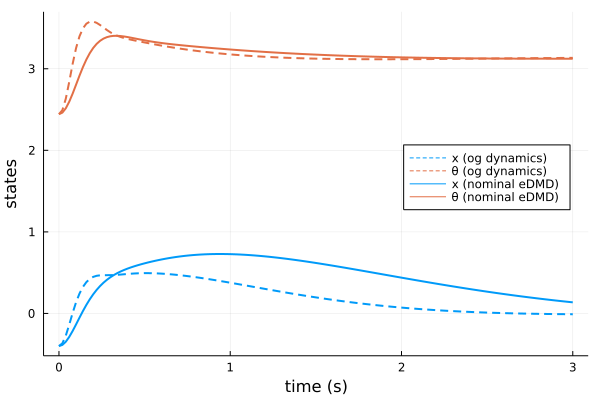

In [25]:
# Simulate nominal model with LQR gain from bilinear model

tf_sim = 3.0
Tsim_lqr_nominal = range(0,tf_sim,step=dt)

# x0 = [0,pi-deg2rad(1),0,0]
x0 = [-0.4,pi-deg2rad(40),0,0]

ctrl_lqr_og = LQRController(K_og, xe, ue)
ctrl_lqr_nominal = LQRController(K_bil_nom, xe, ue)

Xsim_lqr_og, = simulatewithcontroller(dmodel, ctrl_lqr_og, x0, tf_sim, dt)
Xsim_lqr_nominal, = simulatewithcontroller(dmodel, ctrl_lqr_nominal, x0, tf_sim, dt)

plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (og dynamics)" "θ (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "θ (nominal eDMD)"], legend=:right, lw=2,
            color=[1 2])

# Evaluate New eDMD Model with Penalties on Jacobians
Here we incorporate derivative data by penalizing the difference of the Jacobian of the learned model from the expected Jacobians of the nominal model, e.g.:

$$ \sum_{j=1}^P || \frac{\partial}{\partial x} G \hat{f}(\varphi(x_j), u_j) - A_j ||^2 $$

where 

$$ \hat{f}(y,u) = A y + B u + \sum_{i=1}^m u_i C_i y $$

are the learned bilinear dynamics.

In [26]:
# Generate Jacobians
xn = zeros(n0)
jacobians = map(CartesianIndices(U_train)) do cind
    k = cind[1]
    x = X_train[cind]
    u = U_train[cind]
    z = RD.KnotPoint{n0,m}(x,u,T_ref[k],dt)
    J = zeros(n0,n0+m)
    RD.jacobian!(
        RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, z 
    )
    J
end
A_train = map(J->J[:,1:n0], jacobians)
B_train = map(J->J[:,n0+1:end], jacobians)

# Convert states to lifted Koopman states
Y_train = map(kf, X_train)

# Calculate Jacobian of Koopman transform
F_train = map(@view X_train[1:end-1,:]) do x
    sparse(ForwardDiff.jacobian(x->expandstate(model_bilinear,x), x))
end;

### Build Least-squares problem
Find the eDMD data `A`, `B`, and `C` that minimize the following residual:

$$\sum_{j=1}^P (1-\alpha)|| A y_j + B u_j + \sum_{i=1}^m u_{j,i} C_i x_j - y_j^+ ||^2 + 
\alpha || G (A + \sum_{i=1}^m u_{j,i} C_j) F_j  - A_j ||^2 + 
\alpha || G (B + [C_1 x_j \dots C_m x_j]) - B_j ||^2  $$

where $F_j = \partial \varphi(x_j) / \partial x$.

This is equivalent to 

$$ (1-\alpha)|| E Z_{1:P} - Y_{1:P}^+ ||^2 + 
\alpha || G E \hat{A}_{1:P} - A_{1:P} ||^2 +
\alpha || G E \hat{B}_{1:P} - B_{1:P} ||^2 $$

where

$$ E = \begin{bmatrix} A & B & C_1 & \dots & C_m \end{bmatrix} \in \mathbb{R}^{n \times p} $$
$$ Z_j = \begin{bmatrix} 
    x_j \\ u_j \\ u_{j,1} x_j \\ \vdots \\ u_{j,m} x_j 
\end{bmatrix} \in \mathbb{R}^{p}, \quad
\hat{A}_j = \begin{bmatrix} 
    I_n \\ 0_{m,n} \\ u_{j,1} I_n \\ \vdots \\ u_{j,m} I_n 
\end{bmatrix} \in \mathbb{R}^{p \times n}, \quad
\hat{B}_j = \begin{bmatrix} 
    0_{n,m} \\ I_m \\ [x_j \; 0 \; \dots \; 0] \\ \vdots \\ [0 \; \dots \; 0 \; x_j] 
\end{bmatrix} \in \mathbb{R}^{p \times m}
$$

which is equivalent to 

$$ \left\lVert 
\begin{bmatrix} 
    Z_{1:P}^T \otimes I_n \\
    \hat{A}_{1:P}^T \otimes G \\
    \hat{B}_{1:P}^T \otimes G 
\end{bmatrix} \text{vec}(E) - 
\begin{bmatrix}
    \text{vec}{Y_{1:P}^+}\\
    \text{vec}{A_{1:P}^+}\\
    \text{vec}{B_{1:P}^+}\\
\end{bmatrix}
\right\rVert^2 $$

In [27]:
# Create a sparse version of the G Jacobian
G = spdiagm(n0,n,1=>ones(n0)) 
@test norm(G - model_bilinear.g) < 1e-8

# Build Least Squares Problem
W,s = BilinearControl.EDMD.build_edmd_data(
    Z_train, U_train, A_train, B_train, F_train, model_bilinear.g
);

Concatentating data
Creating feature matrix
Creating state Jacobian matrix
Creating control Jacobian matrix
Creating least-squares data


### Solve the Least-squares Problem

In [28]:
@time Wsparse = sparse(W)
@time F = qr(Wsparse)
@time x = F \ s
norm(W*x - s)

 11.477233 seconds (451.15 k allocations: 1.349 GiB, 3.16% gc time, 0.84% compilation time)
 52.127978 seconds (623 allocations: 27.529 GiB, 1.55% gc time, 0.02% compilation time)
  1.857413 seconds (33 allocations: 34.782 MiB, 0.46% gc time, 0.15% compilation time)


13671.16757513551

In [29]:
BilinearControl.matdensity(Wsparse)

0.1292593635595607

In [30]:
# Extract out bilinear dynamics
n = length(Z_train[1])
E = reshape(x,n,:)
A = E[:,1:n]
B = E[:,n .+ (1:m)]
C = E[:,n+m .+ (1:n*m)]

C_list = Matrix{Float64}[]
    
for i in 1:m
    C_i = C[:, (i-1)*n+1:i*n]
    push!(C_list, C_i)
end

return A, B, C_list, Matrix(g)

C = C_list;

In [31]:
# Save data
jldsave(joinpath(Problems.DATADIR,"cartpole_lqr_jacobian_penalized_eDMD_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

# Import New Model

In [32]:
cartpole_data = load(joinpath(Problems.DATADIR, "cartpole_lqr_jacobian_penalized_eDMD_data.jld2"))
A_jacpen = cartpole_data["A"]
B_jacpen = cartpole_data["B"]
C_jacpen = cartpole_data["C"]
g_jacpen = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"]

T_ref = range(0,tf,step=dt);

# Evaluate the New Fit

In [33]:
# Evaluate the Fit
err_train2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_train, U_train)
err_test2 = BilinearControl.EDMD.fiterror(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, X_test, U_test)
println("Train Error: ", err_train)
println("Test Error:  ", err_test)
println("")
println("New Train Error: ", err_train2)
println("New Test Error:  ", err_test2)

Train Error: 0.0034957043768757694
Test Error:  0.008698930470642706

New Train Error: 0.0062163136534720545
New Test Error:  0.006365613094846368


In [34]:
model_bilinear_jacpen = EDMDModel(A_jacpen, B_jacpen, C_jacpen, g_jacpen, kf, dt, "cartpole")
n,m = RD.dims(model_bilinear_jacpen)
n0 = originalstatedim(model_bilinear_jacpen);

In [35]:
# Get A,B for new system
function dynamics_bilinear_jacpen(x,u,t,dt)
    y = expandstate(model_bilinear_jacpen, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear_jacpen, yn, y, u, t, dt)
    originalstate(model_bilinear_jacpen, yn)
end

A_bil_jacpen = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear_jacpen(x,ue,0.0,dt), xe)
B_bil_jacpen = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear_jacpen(xe,u,0.0,dt), ue);

**Compare the Jacobians with Nominal model**

In [36]:
A_og

4×4 Matrix{Float64}:
 1.0  0.000392055   0.019998     -1.38375e-6
 0.0  1.0047       -3.99648e-6    0.0199834
 0.0  0.0392035     0.9998       -7.57316e-6
 0.0  0.470481     -0.000399628   0.999909

In [37]:
A_bil_jacpen

4×4 Matrix{Float64}:
 1.0          0.000384806   0.0199987   -1.10295e-6
 2.47359e-6   1.0047       -1.3113e-6    0.0199848
 7.52507e-5   0.0386225     0.999888     3.14119e-5
 0.000321389  0.470412     -3.24245e-5   1.00011

In [38]:
B_og

4×1 Matrix{Float64}:
 0.00019995956333333334
 0.00039964806000000004
 0.01999523290316667
 0.03996279079433334

In [39]:
B_bil_jacpen

4×1 Matrix{Float64}:
 0.00019874977174083597
 0.0004000663757324219
 0.0198978412249744
 0.04012235753089044

# Try Stabilizing New Model using LQR

In [40]:
K_bil_jacpen = dlqr(A_bil_jacpen, B_bil_jacpen, Qlqr, Rlqr);

In [41]:
# Evaluate stability
isstable_bilinear2 = maximum(abs.(eigvals(A_bil_jacpen - B_bil_jacpen*K_bil_jacpen))) < 1.0
isstable_nominal_with_bilinear2 = maximum(abs.(eigvals(A_og - B_og*K_bil_jacpen))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear2)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear2)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  true


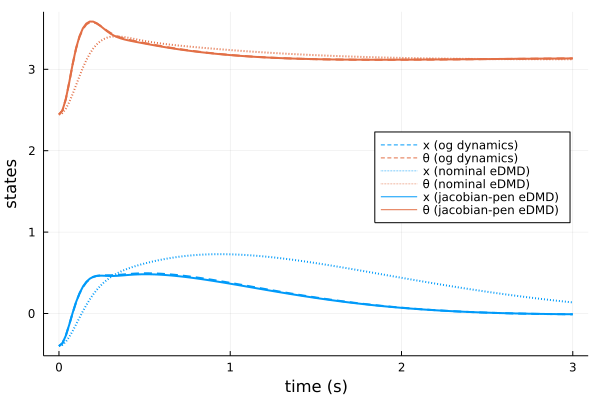

In [42]:
tf_sim = 3.0
Tsim_lqr_jacpen = range(0,tf_sim,step=dt)

x0 = [-0.4,pi-deg2rad(40),0,0]

ctrl_lqr_jacpen = LQRController(K_bil_jacpen, xe, ue)
Xsim_lqr_jacpen, = simulatewithcontroller(dmodel, ctrl_lqr_jacpen, x0, tf_sim, dt)

plotstates(Tsim_lqr_nominal, Xsim_lqr_og, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (og dynamics)" "θ (og dynamics)"], legend=:right, lw=2,
            linestyle=:dash, color=[1 2])
plotstates!(Tsim_lqr_nominal, Xsim_lqr_nominal, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (nominal eDMD)" "θ (nominal eDMD)"], legend=:right, lw=2,
            linestyle=:dot, color=[1 2])
plotstates!(Tsim_lqr_jacpen, Xsim_lqr_jacpen, inds=1:2, xlabel="time (s)", ylabel="states",
            label=["x (jacobian-pen eDMD)" "θ (jacobian-pen eDMD)"], legend=:right, lw=2,
            color=[1 2])

In [43]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8702))

In [44]:
# visualize!(vis, model, tf_sim, Xsim_lqr_nominal)
visualize!(vis, model, tf_sim, Xsim_lqr_jacpen)